In [1]:
from collections import Counter
import itertools
import json
import os
import random
import sys 
 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pycocotools.coco import COCO
import pylab
from skimage import io
import torch

In [2]:
%load_ext autoreload

In [3]:
%autoreload

In [4]:
# os.chdir('../')
sys.path.append("../utils/")
from plot_utils import EmbeddingPlotter as ep

In [5]:
sys.path.append('../dataset/')
import coco_api_helper

loading annotations into memory...
Done (t=11.85s)
creating index...
index created!
loading annotations into memory...
Done (t=5.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


### Load embeddings and embedding to image mapping

In [6]:
# Read embeddings. Change filepaths as needed to visualize your embeddings
embeddings_fp = "../data/torch_embeddings/densenet_inspired"
embeddings_path = f"{embeddings_fp}/di_embed_val_batch_41.pt"
mapping_path = f"{embeddings_fp}/di_index2cocoIDs.json"

embeddings = torch.load(embeddings_path, map_location=torch.device('cpu'))

with open(mapping_path, 'r') as fp:
    idx2Img = json.load(fp)
    
idx2Img = dict(zip(list(map(int, idx2Img.keys())), list(idx2Img.values())))

### Global Variables

In [7]:
# Update based on the location in your system
annot_file = "../data/raw/train/annotations/instances_val2014.json"

In [8]:
val_coco = coco_api_helper.coco_objects['valid']

def plot_one_coco_img(coco_id: int, coco_api_obj = val_coco):
    loaded_img = coco_api_obj.loadImgs(coco_id)[0]['coco_url']
    read_img = io.imread(loaded_img)
    plt.imshow(read_img)

### Query images and their position in embedding space

In [9]:
# Img Ids to query
random.seed(10)
query_images = random.sample(list(idx2Img.values()), 10)

# Position of query images in embedding space
query_idxs = [key for key, value in idx2Img.items() if idx2Img[key] in query_images]

print("query image ids: ", query_images)
print("query image idxs: ", query_idxs)

query image ids:  [495291, 100582, 547338, 223243, 87414, 78915, 38210, 70280, 455188, 263723]
query image idxs:  [486, 1067, 6753, 9093, 14053, 15157, 15812, 16098, 18723, 18942]


In [10]:
len(query_images) // 5

2

### Plot Retrieval Images for each Query Image

In [11]:
class EmbeddingPlotter:
    
    def __init__(self, annot_filepath: str, embeddings: torch.Tensor, idx2img_map: dict):
        """
        :annot_filepath: filepath to validaton annotation file
        :embeddings: pytorch tensor (list) of embeddings
        :idx2img_map: dictionary of keys as embeddings index and values of corresponding coco image id
        """
        self.coco = COCO(annot_filepath)
        
        self.idx2Img = idx2img_map
        self.img_ids = list(idx2img_map.values())
        self.ann_ids = self.coco.getAnnIds(self.img_ids)
        
        self.embeddings = embeddings
            
        cats = self.coco.loadCats(self.coco.getCatIds())
        cats_dict = {cat['id']: cat for cat in cats}
        
        self.labels = []
        for k, v in self.idx2Img.items():
            ann_ids_to_append = self.coco.getAnnIds(self.idx2Img[k])
            anns_to_append = self.coco.loadAnns(ann_ids_to_append)
            self.labels.append(anns_to_append)
            
        self.category_labels= []
        self.supercategory_labels = []
        
        for label in self.labels:
            if len(label) > 0:
                categories = []
                supercategories = []

                for annotation in label:
                    categories.append(cats_dict[annotation['category_id']]['name'])
                    supercategories.append(cats_dict[annotation['category_id']]['supercategory'])

                # most common category among objects in the picture
                category, _ = Counter(categories).most_common(1)[0]
                supercategory, _ = Counter(supercategories).most_common(1)[0]

                self.category_labels.append(category)
                self.supercategory_labels.append(supercategory)
            else:
                self.category_labels.append(None)
                self.supercategory_labels.append(None)   
                
    def plot_coco_images (self, img_ids: list, imgs_per_row: int = 7, figtitle: str = None):
        """
        :coco_img_ids: 
        :imgs_per_row: images per row to display
        """
        n_cols = imgs_per_row
        n_rows = len(img_ids[0]) // imgs_per_row + 1

        fig = plt.figure(1, figsize=(int(n_rows * imgs_per_row), int(2 * imgs_per_row)))
        for i, img_id in enumerate(itertools.chain(*img_ids)):
            ax = fig.add_subplot(n_rows, n_cols, i + 1)
            img = io.imread(self.coco.loadImgs(img_id)[0]['coco_url'])
            ax.imshow(img, aspect='equal')
            ax.axis('off')
        plt.tight_layout()
        
        if figtitle:
            fig.suptitle(figtitle)
            plt.subplots_adjust(top=0.90)
        plt.show()
        
    def plot_neighbors (self, X_idx, nbrs, show_annotations=False):
        idx2Img = self.idx2Img
        embeddings = self.embeddings
        
        m, n = np.shape(embeddings)
        num_emb, emb_dim = np.shape(embeddings)
        img_id = idx2Img[X_idx]
        
        distances, indices = nbrs.kneighbors(embeddings[X_idx, :].reshape(1, emb_dim), nbrs.n_neighbors)
        # distances & indices shaped like this = [[elem1, elem2, ... elemN]]
        
        distances, indices = distances[0], indices[0]
        neighbors_ids = np.array(list(map(idx2Img.get, indices)))
        np.insert(neighbors_ids, 0, img_id)
        np.insert(distances, 0, 0)
        
        title_suffix = np.array([f'distance={distance:.2f}' for distance in distances])
        figtitle=f'Neighbors of {img_id}'
        
        num_imgs_per_row = 7
        if nbrs.n_neighbors > 7:
            num_imgs_per_row = nbrs.n_neighbors // 7
        
        self.plot_coco_images(neighbors_ids.reshape(len([img_id]), 
                                                    len(indices) // len([img_id])).tolist(), 
                              imgs_per_row = num_imgs_per_row,
                              figtitle=figtitle)

In [23]:
emb_plt = EmbeddingPlotter(annot_file, embeddings, idx2Img)

loading annotations into memory...
Done (t=4.10s)
creating index...
index created!


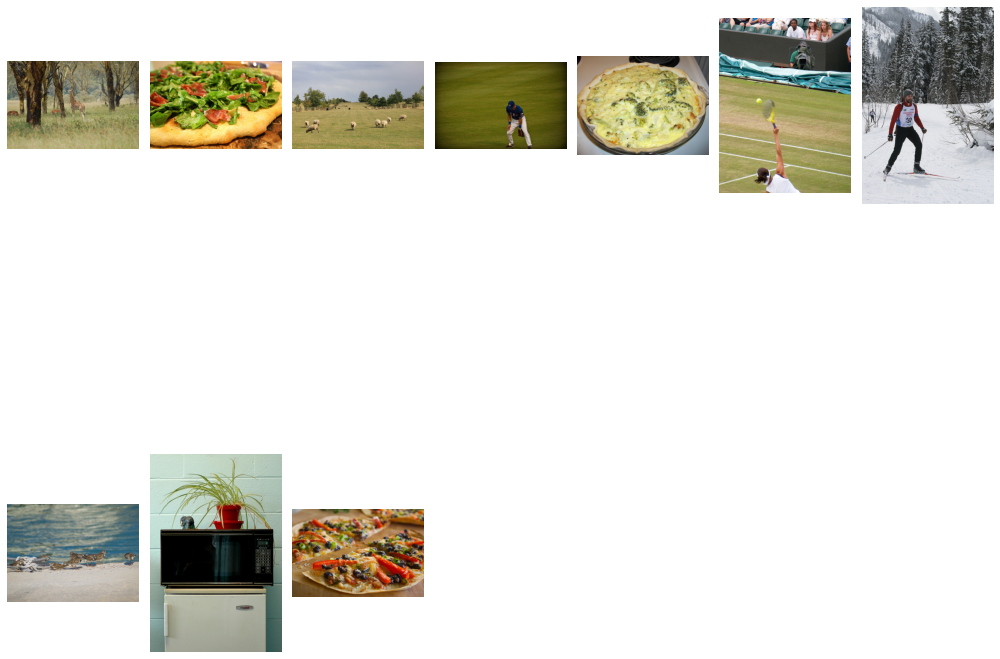

In [24]:
emb_plt.plot_coco_images([query_images])

# Use K-Neighbors to find similar images across embedded space

In [25]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=7, 
                        algorithm='auto', 
                        metric='cosine').fit(embeddings)

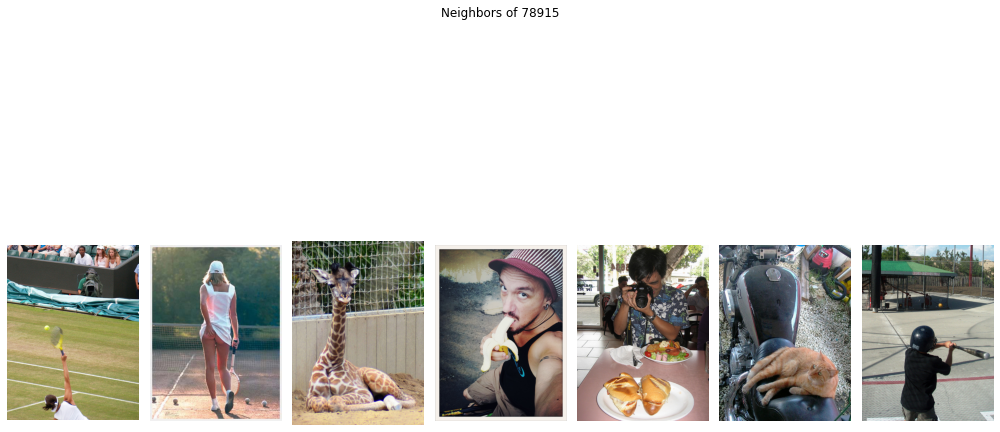

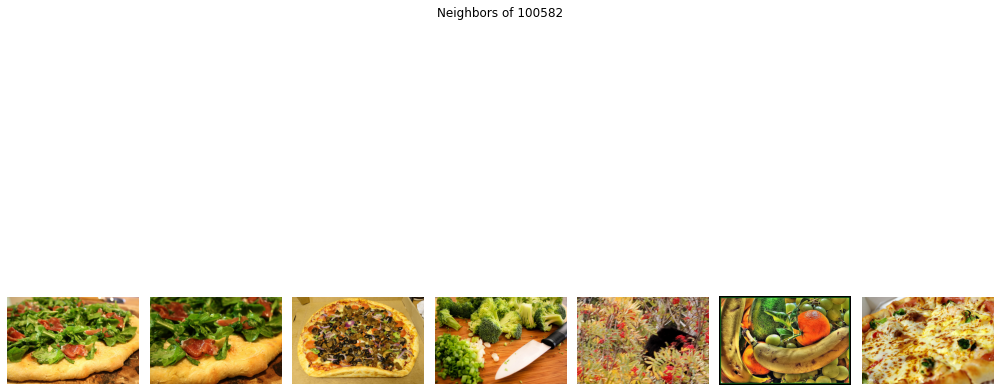

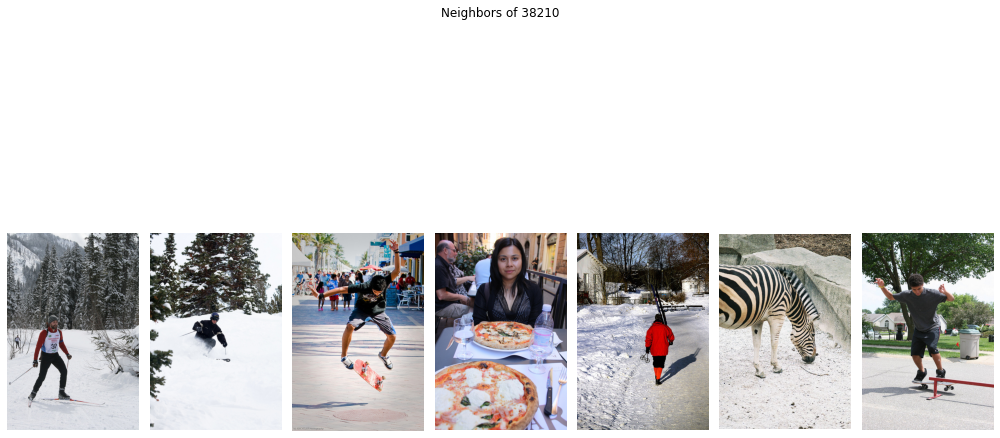

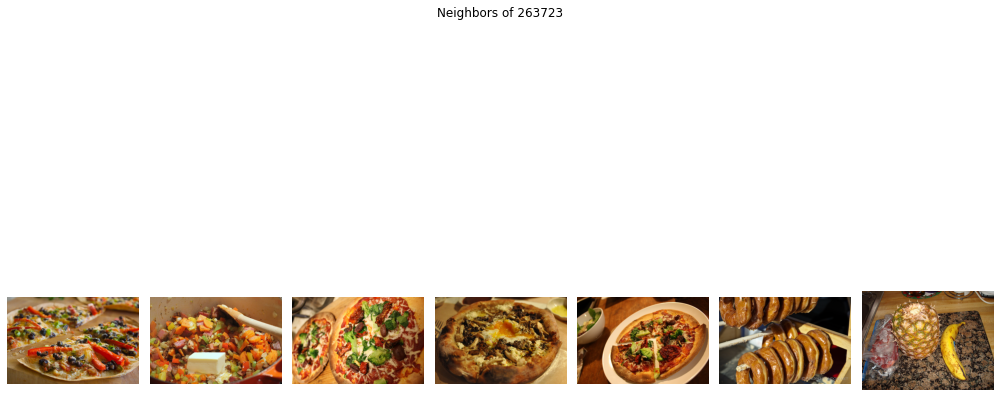

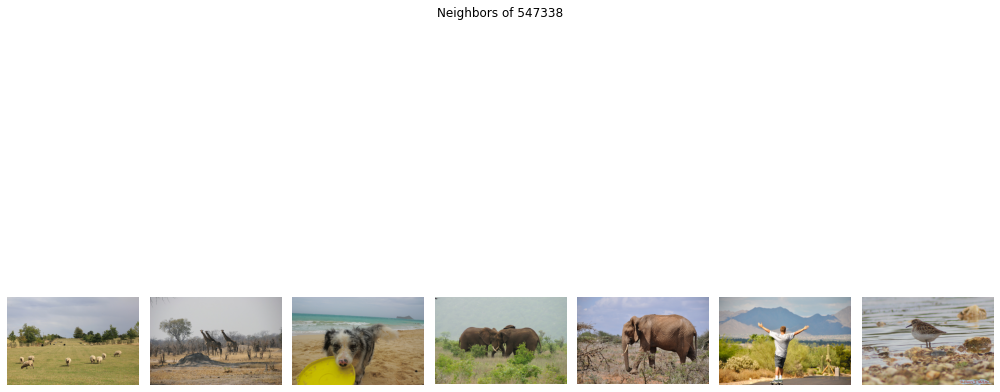

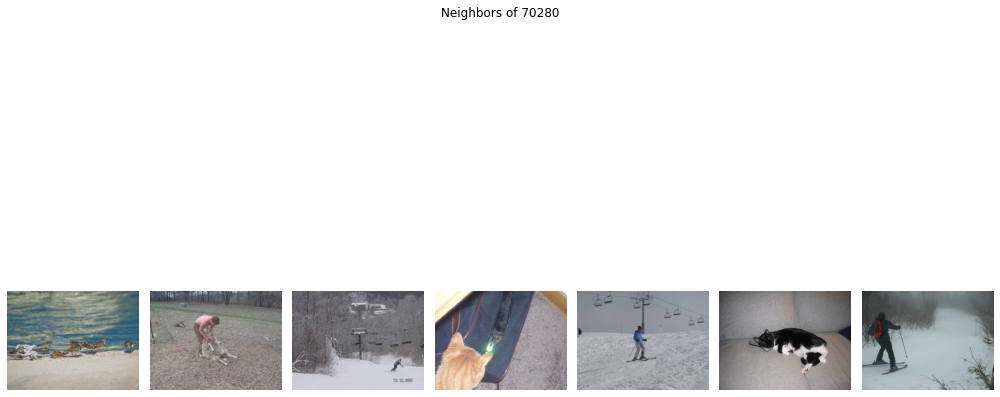

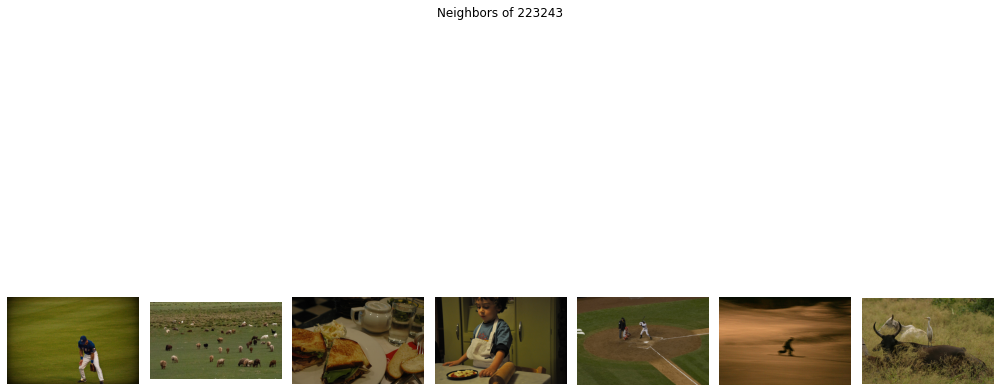

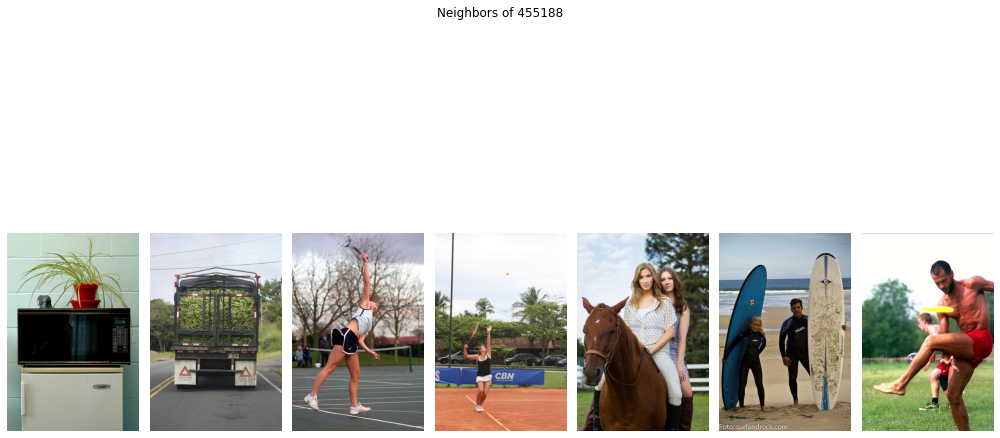

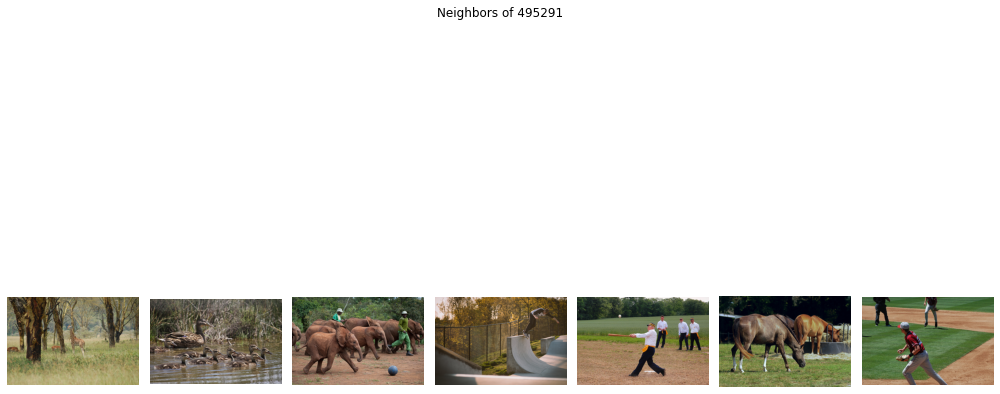

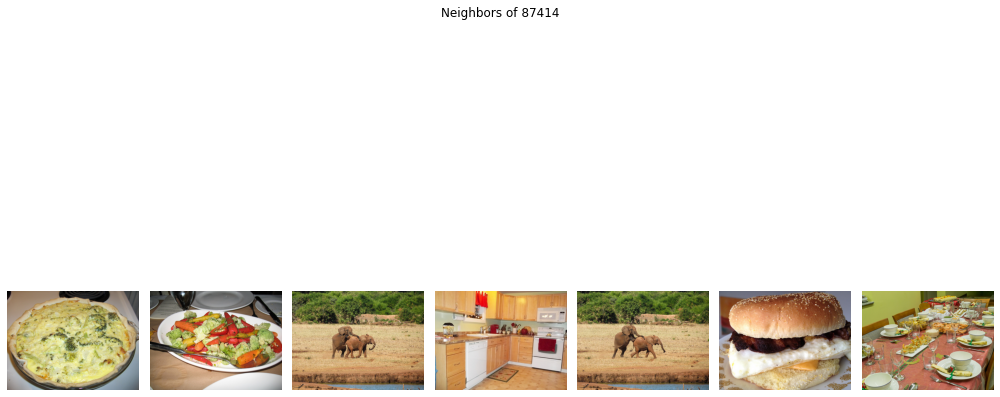

[None, None, None, None, None, None, None, None, None, None]

In [26]:
# Recall that plot_neighbors takes index position of embeddings as input
[emb_plt.plot_neighbors(emb_idx, nbrs=nbrs) for emb_idx in query_idxs]

# PCA on Embeddings

In [27]:
embeddings.shape[1]

1024

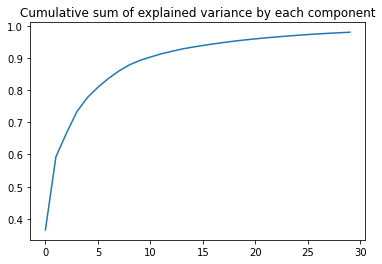

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X_pca = pca.fit_transform(embeddings)
plt.plot(range(X_pca.shape[1]), np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative sum of explained variance by each component')
plt.show()

# Search Precision

In [29]:
from operator import itemgetter

def precision(plotter, idx, nbrs, category=True, reduced_space=None):
    if reduced_space is None:
        embeddings = plotter.embeddings
        m, n = embeddings.size()
    else:
        embeddings = reduced_space
        m, n = np.shape(embeddings)
    distances, indices = nbrs.kneighbors(embeddings[idx, :].reshape(1, n), 16)
    distances = distances[0][1:]
    indices = indices[0][1:]
    if category == True:
        ground_truth = plotter.category_labels[idx]
        retrieved_labels = itemgetter(*indices)(plotter.category_labels)
    else:
        ground_truth = plotter.supercategory_labels[idx]
        retrieved_labels = itemgetter(*indices)(plotter.supercategory_labels)
        
    precision = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(retrieved_labels)
    return precision

In [33]:
def avg_precision(plotter, nbrs, query_idxs, category=True, reduced_space=None):
    avg_precision = 0
    for idx in query_idxs:
        avg_precision += precision(emb_plt, idx, nbrs, category, reduced_space)
    avg_precision = avg_precision / len(query_idxs)
    return avg_precision

In [35]:
category_precision = avg_precision(emb_plt, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(emb_plt, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 36.67%
Supercategory-level precision: 13.33%


# Search Precision by K-Neighbors Distance Metric

In [36]:
# Cosine Distance
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine').fit(embeddings)
category_precision = avg_precision(emb_plt, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(emb_plt, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 36.67%
Supercategory-level precision: 13.33%


In [37]:
# Minkowski Distance
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='minkowski').fit(embeddings)
category_precision = avg_precision(emb_plt, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(emb_plt, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 31.33%
Supercategory-level precision: 9.33%


In [38]:
# Euclidean Distance
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean').fit(embeddings)
category_precision = avg_precision(emb_plt, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(emb_plt, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 31.33%
Supercategory-level precision: 9.33%


In [39]:
# Manhattan Distance
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='manhattan').fit(embeddings)
category_precision = avg_precision(emb_plt, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(emb_plt, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 31.33%
Supercategory-level precision: 8.67%


# Search Precision in Reduced Space

In [40]:
# Cosine Distance
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine').fit(X_pca[:, :3])
category_precision = avg_precision(emb_plt, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :3])
supercategory_precision = avg_precision(emb_plt, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :3])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 40.0%
Supercategory-level precision: 14.0%


In [41]:
# Minkowski Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='minkowski').fit(X_pca[:, :3])
category_precision = avg_precision(emb_plt, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :3])
supercategory_precision = avg_precision(emb_plt, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :3])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 37.33%
Supercategory-level precision: 18.0%


In [42]:
# Euclidean Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='euclidean').fit(X_pca[:, :3])
category_precision = avg_precision(emb_plt, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :3])
supercategory_precision = avg_precision(emb_plt, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :3])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 37.33%
Supercategory-level precision: 18.0%


In [43]:
# Minkowski Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='manhattan').fit(X_pca[:, :3])
category_precision = avg_precision(emb_plt, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :3])
supercategory_precision = avg_precision(emb_plt, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :3])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 34.67%
Supercategory-level precision: 14.67%
